# Preliminary data examination
In this notebook, the received data was examined. The cleaning functions created later are based on this examination of the datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from pathlib import Path
import os

In [2]:
# Path to the main directory
main_dir_path = Path.cwd().parents[0]

# Path to the raw data dir
raw_data_path = os.path.join(main_dir_path, 'raw_data')

# List of all .txt files in raw data dir
path_list = list(Path(raw_data_path).glob('*.txt'))
file_name_list = [re.sub('\.txt$', '', path.name) for path in path_list]
file_dict = dict(zip(file_name_list, path_list))

In [3]:
# Printing all file names
for file_name in file_name_list:
    print(file_name)

monthly_avg_relative_humidity
monthly_avg_solar_radiation
monthly_avg_sun_duration
monthly_avg_temperature
monthly_avg_wind_speed
monthly_max_global_solar_radiation
monthly_max_relative_humidity
monthly_max_temperature
monthly_min_relative_humidity
monthly_min_temperature
monthly_total_global_solar_radiation
monthly_total_sun_duration
station_definitions


## Station definitions
This dataset contains the number, name, location, and latitude/longitude of each station.
* There is a total of 1298 stations
* Station numbers are unique
* There are 4 negative elevation values
* Names have ? signs in places of Turkish letters

In [4]:
df = pd.read_csv(file_dict['station_definitions'], sep='|')

rename_dict = {
    '?stasyon Numaras?': 'st_num',
    '?stasyon Ad?': 'st_name',
    '?l': 'province',
    '?l?e': 'district',
    'Enlem': 'latitude',
    'Boylam': 'longitude',
    'Rak?m': 'elevation'
}

df = df.rename(columns=rename_dict)

# Renaming provinces with missing letters
rename_dict = {
    'D?zce': 'Düzce',
    'Bart?n': 'Bartın',
    '?stanbul': 'İstanbul',
    'K?rklareli': 'Kırklareli',
    'Karab?k': 'Karabük',
    '?ank?r?': 'Çankırı',
    '?orum': 'Çorum',
    'G?m??hane': 'Gümüşhane',
    'A?r?': 'Ağrı',
    'I?d?r': 'Iğdır',
    '?anakkale': 'Çanakkale',
    'Bal?kesir': 'Balıkesir',
    'Eski?ehir': 'Eskişehir',
    'K?r?kkale': 'Kırıkkale',
    'K?tahya': 'Kütahya',
    'K?r?ehir': 'Kırşehir',
    '?zmir': 'İzmir',
    'Nev?ehir': 'Nevşehir',
    'Elaz??': 'Elazığ',
    'Bing?l': 'Bingöl',
    'Mu?': 'Muş',
    'Ayd?n': 'Aydın',
    'Ni?de': 'Niğde',
    'Kahramanmara?': 'Kahramanmaraş',
    'Ad?yaman': 'Adıyaman',
    'Diyarbak?r': 'Diyarbakır',
    'Mu?la': 'Muğla',
    '?anl?urfa': 'Şanlıurfa',
    'Tekirda?': 'Tekirdağ',
    '??rnak': 'Şırnak',
    'U?ak': 'Uşak'
}

df['province'] = df['province'].str.strip()
df['province'] = df['province'].replace(rename_dict)

In [5]:
df.head()

,st_num,st_name,province,district,latitude,longitude,elevation
0,17015,AK?AKOCA,Düzce,Ak?akoca,41.0895,31.1374,10.0
1,17020,BARTIN,Bartın,Merkez,41.6248,32.3569,33.0
2,17024,?NEBOLU,Kastamonu,?nebolu,41.9789,33.7636,64.0
3,17033,ORDU,Ordu,Merkez,40.9838,37.8858,5.0
4,17034,G?RESUN,Giresun,Merkez,40.9227,38.3878,38.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   st_num     1298 non-null   int64  
 1   st_name    1298 non-null   object 
 2   province   1298 non-null   object 
 3   district   1255 non-null   object 
 4   latitude   1298 non-null   float64
 5   longitude  1298 non-null   float64
 6   elevation  1297 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 71.1+ KB


Station numbers are unique

In [7]:
df['st_num'].nunique()

1298

Checking for unreasonable values

In [8]:
cond = df['elevation'] < 0
cond.sum()

4

In [9]:
df.loc[cond]

,st_num,st_name,province,district,latitude,longitude,elevation
867,17394,S?L?FKE/TA?UCU A?IKLARI ?AMANDIRA,Mersin,Silifke,36.0833,33.8333,-180.0
868,17390,?STANBUL BO?AZI KARADEN?Z ?IKI?I ?AMANDIRA,İstanbul,Beykoz,41.2922,29.1656,-50.0
869,17393,ANTALYA K?RFEZ? ?AMANDIRA,Antalya,Serik,36.7167,31.0167,-330.0
872,17392,KUZEY EGE ?ANAKKALE BO?AZI ?IKI?I ?AMANDIRA,Çanakkale,Eceabat,40.0483,26.0356,-70.0


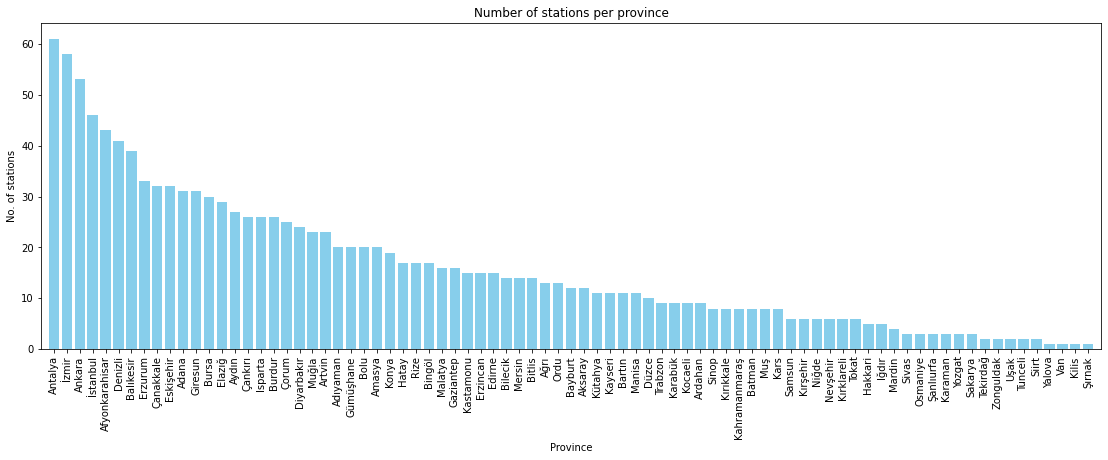

In [10]:
graph_data = df[['st_num', 'province']].groupby('province').count().reset_index().rename(columns={'st_num': 'st_count'})
graph_data = graph_data.sort_values(by='st_count', ascending=False)

plt.figure(figsize=(19, 6))
plt.bar('province', 'st_count', data=graph_data, color='skyblue')
plt.xlabel('Province')
plt.ylabel('No. of stations')
plt.xticks(rotation=90)
plt.xlim(-1, 81)
plt.title('Number of stations per province')
plt.show()

## Exploring measured variable datasets

In [13]:
def explore_dataset(file_name, var_name='variable'):
    '''
    1.  Renames the common columns (Turkish to English) and the variable column
        to the defined var_name
        
    2.  Displays data description
    
    3.  Displays the dataframe information
    
    4.  Prints the start and end years and the total number of years
    
    5.  Returns the dataset with renamed columns
    '''
    
    path = file_dict[file_name]
    
    df = pd.read_csv(path, sep='|')
    
    rename_dict = {
        'Istasyon_No': 'st_num',
        'Istasyon_Adi': 'st_name',
        'YIL': 'year',
        'AY': 'month'
    }
    
    
    rename_dict[df.columns[-1]] = var_name
    df = df.rename(columns=rename_dict)
    
    # Showing data description (excluding month 13 data)
    cond = df['month'] != 13
    display(df.loc[cond].describe())
    
    # Showing dataframe information
    display(df.info())
    
    print(f"Start year: {df['year'].min()}")
    print(f"End year: {df['year'].max()}")
    print(f"Number of years: {df['year'].nunique()}")
          
    return df

### Max Temperature
* Measurement dates range between 1960 and 2021
* Temperatures are in Celsius

In [15]:
file_name = 'monthly_max_temperature'
df = explore_dataset(file_name, var_name='max_temp')

,st_num,year,month,max_temp
count,239287.000000,239287.000000,239287.000000,239287.000000
mean,17602.704581,2000.880984,6.447141,25.629870
std,1682.857128,18.066758,3.454303,8.927919
min,1708.000000,1960.000000,1.000000,-15.400000
25%,17248.000000,1986.000000,3.000000,19.100000
50%,17726.000000,2007.000000,6.000000,26.300000
75%,17964.000000,2017.000000,9.000000,32.900000
max,19991.000000,2021.000000,12.000000,48.800000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257861 entries, 0 to 257860
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   st_num    257861 non-null  int64  
 1   st_name   257861 non-null  object 
 2   year      257861 non-null  int64  
 3   month     257861 non-null  int64  
 4   max_temp  257861 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.8+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Minimum Temperature

In [16]:
file_name = 'monthly_min_temperature'
df = explore_dataset(file_name, var_name='min_temp')

,st_num,year,month,min_temp
count,238102.000000,238102.000000,238102.000000,238102.000000
mean,17602.396141,2001.086568,6.446964,1.958630
std,1688.102131,17.882280,3.454702,9.573058
min,1708.000000,1960.000000,1.000000,-47.300000
25%,17248.000000,1987.000000,3.000000,-4.000000
50%,17726.000000,2007.000000,6.000000,2.100000
75%,17965.000000,2017.000000,9.000000,9.000000
max,19991.000000,2021.000000,12.000000,31.900000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256644 entries, 0 to 256643
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   st_num    256644 non-null  int64  
 1   st_name   256644 non-null  object 
 2   year      256644 non-null  int64  
 3   month     256644 non-null  int64  
 4   min_temp  256644 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.8+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Average Temperature

In [17]:
file_name = 'monthly_avg_temperature'
df = explore_dataset(file_name, var_name='avg_temp')

,st_num,year,month,avg_temp
count,247062.000000,247062.000000,247062.000000,247062.000000
mean,17588.717613,2000.894269,6.446977,13.295580
std,1667.479321,17.923482,3.455050,8.681344
min,1708.000000,1960.000000,1.000000,-24.400000
25%,17240.000000,1987.000000,3.000000,6.800000
50%,17707.000000,2007.000000,6.000000,13.400000
75%,17958.000000,2017.000000,9.000000,20.300000
max,19991.000000,2021.000000,12.000000,39.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265632 entries, 0 to 265631
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   st_num    265632 non-null  int64  
 1   st_name   265632 non-null  object 
 2   year      265632 non-null  int64  
 3   month     265632 non-null  int64  
 4   avg_temp  265632 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 10.1+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Average Wind Speed
* Wind speed in $m/s$

In [18]:
file_name = 'monthly_avg_wind_speed'
df = explore_dataset(file_name, var_name='avg_ws')

,st_num,year,month,avg_ws
count,227355.000000,227355.000000,227355.000000,227355.000000
mean,17477.899118,1999.438024,6.457135,2.283435
std,1687.972469,17.894790,3.453516,1.230033
min,1708.000000,1960.000000,1.000000,0.000000
25%,17221.000000,1985.000000,3.000000,1.500000
50%,17676.000000,2005.000000,6.000000,2.100000
75%,17891.000000,2015.000000,9.000000,2.900000
max,19991.000000,2021.000000,12.000000,30.200000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227355 entries, 0 to 227354
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   st_num   227355 non-null  int64  
 1   st_name  227355 non-null  object 
 2   year     227355 non-null  int64  
 3   month    227355 non-null  int64  
 4   avg_ws   227355 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 8.7+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Maximum Relative Humidity

In [19]:
file_name = 'monthly_max_relative_humidity'
df = explore_dataset(file_name, var_name='max_hum')

,st_num,year,month,max_hum
count,237802.000000,237802.000000,237802.000000,237802.000000
mean,17603.420703,2001.279312,6.450724,94.953953
std,1673.047445,17.889814,3.454584,7.344692
min,1708.000000,1960.000000,1.000000,0.000000
25%,17246.000000,1987.000000,3.000000,94.000000
50%,17726.000000,2008.000000,6.000000,97.000000
75%,17970.000000,2017.000000,9.000000,99.000000
max,19991.000000,2021.000000,12.000000,110.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256178 entries, 0 to 256177
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   st_num   256178 non-null  int64  
 1   st_name  256178 non-null  object 
 2   year     256178 non-null  int64  
 3   month    256178 non-null  int64  
 4   max_hum  256178 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.8+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Minimum Humidity

In [20]:
file_name = 'monthly_min_relative_humidity'
df = explore_dataset(file_name, var_name='min_hum')

,st_num,year,month,min_hum
count,237802.000000,237802.000000,237802.000000,237802.000000
mean,17603.420703,2001.279312,6.450724,22.675713
std,1673.047445,17.889814,3.454584,12.821413
min,1708.000000,1960.000000,1.000000,0.000000
25%,17246.000000,1987.000000,3.000000,13.000000
50%,17726.000000,2008.000000,6.000000,21.000000
75%,17970.000000,2017.000000,9.000000,30.000000
max,19991.000000,2021.000000,12.000000,100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256178 entries, 0 to 256177
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   st_num   256178 non-null  int64  
 1   st_name  256178 non-null  object 
 2   year     256178 non-null  int64  
 3   month    256178 non-null  int64  
 4   min_hum  256178 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.8+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Average Humidity

In [21]:
file_name = 'monthly_avg_relative_humidity'
df = explore_dataset(file_name, var_name='avg_hum')

,st_num,year,month,avg_hum
count,236806.000000,236806.000000,236806.000000,236806.000000
mean,17598.984836,2001.167107,6.449220,65.096828
std,1695.619219,17.908304,3.456085,13.756654
min,1708.000000,1960.000000,1.000000,0.000000
25%,17244.000000,1987.000000,3.000000,56.600000
50%,17726.000000,2008.000000,6.000000,66.600000
75%,17970.000000,2017.000000,9.000000,75.000000
max,19991.000000,2021.000000,12.000000,100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255122 entries, 0 to 255121
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   st_num   255122 non-null  int64  
 1   st_name  255122 non-null  object 
 2   year     255122 non-null  int64  
 3   month    255122 non-null  int64  
 4   avg_hum  255122 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.7+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Global solar radiation monthly total
* Values in $kWh/m^2$
* Dataset contains only 15772 values
* Measurements start from 2005

In [22]:
file_name = 'monthly_total_global_solar_radiation'
df = explore_dataset(file_name, var_name='tot_rad')

,st_num,year,month,tot_rad
count,15772.000000,15772.000000,15772.000000,15772.000000
mean,17814.591872,2015.454603,6.591555,102.996906
std,661.887649,3.744592,3.430985,81.179359
min,17015.000000,2005.000000,1.000000,0.000000
25%,17234.000000,2013.000000,4.000000,41.100000
50%,17749.000000,2015.000000,7.000000,95.100000
75%,18222.000000,2019.000000,10.000000,166.825000
max,19991.000000,2021.000000,12.000000,731.600000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15772 entries, 0 to 15771
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   st_num   15772 non-null  int64  
 1   st_name  15772 non-null  object 
 2   year     15772 non-null  int64  
 3   month    15772 non-null  int64  
 4   tot_rad  15772 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 616.2+ KB


None

Start year: 2005
End year: 2021
Number of years: 17


### Global solar radiation monthly maximum
* Values in $W/m^2$
* Dataset contains only 15667 values
* Measurements start from 2005

In [23]:
file_name = 'monthly_max_global_solar_radiation'
df = explore_dataset(file_name, var_name='max_rad')

,st_num,year,month,max_rad
count,15667.000000,15667.000000,15667.000000,1.566700e+04
mean,17815.094785,2015.437225,6.589264,2.978475e+05
std,662.714758,3.735554,3.426322,1.956810e+05
min,17015.000000,2005.000000,1.000000,0.000000e+00
25%,17234.000000,2013.000000,4.000000,1.707638e+05
50%,17749.000000,2015.000000,7.000000,3.174000e+05
75%,18224.000000,2019.000000,10.000000,4.596000e+05
max,19991.000000,2021.000000,12.000000,1.423002e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15667 entries, 0 to 15666
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   st_num   15667 non-null  int64  
 1   st_name  15667 non-null  object 
 2   year     15667 non-null  int64  
 3   month    15667 non-null  int64  
 4   max_rad  15667 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 612.1+ KB


None

Start year: 2005
End year: 2021
Number of years: 17


### Solar radiation monthly average
* Values in $cal/cm^2$
* Dataset has only 50968 values
* Values date back to 1965

In [24]:
file_name_list

['monthly_avg_relative_humidity',
 'monthly_avg_solar_radiation',
 'monthly_avg_sun_duration',
 'monthly_avg_temperature',
 'monthly_avg_wind_speed',
 'monthly_max_global_solar_radiation',
 'monthly_max_relative_humidity',
 'monthly_max_temperature',
 'monthly_min_relative_humidity',
 'monthly_min_temperature',
 'monthly_total_global_solar_radiation',
 'monthly_total_sun_duration',
 'station_definitions']

In [25]:
file_name = 'monthly_avg_solar_radiation'
df = explore_dataset(file_name, var_name='avg_rad')

,st_num,year,month,avg_rad
count,50968.000000,50968.000000,50968.000000,50968.000000
mean,17445.339488,1996.228202,6.467882,351.885921
std,383.731764,12.824309,3.453600,159.346949
min,17015.000000,1965.000000,1.000000,0.000000
25%,17175.000000,1988.000000,3.000000,209.100000
50%,17282.000000,1996.000000,6.000000,349.900000
75%,17740.000000,2004.000000,9.000000,481.925000
max,19991.000000,2021.000000,12.000000,1918.300000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50968 entries, 0 to 50967
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   st_num   50968 non-null  int64  
 1   st_name  50968 non-null  object 
 2   year     50968 non-null  int64  
 3   month    50968 non-null  int64  
 4   avg_rad  50968 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.9+ MB


None

Start year: 1965
End year: 2021
Number of years: 57


### Total Monthly Sunlight Duration
* Values in hours

In [26]:
file_name = 'monthly_total_sun_duration'
df = explore_dataset(file_name, var_name='total_sun_duration')

,st_num,year,month,total_sun_duration
count,89673.000000,89673.000000,89673.000000,89673.000000
mean,17438.810288,1997.140031,6.517581,199.573923
std,381.441414,15.538776,3.451234,103.048676
min,17015.000000,1960.000000,1.000000,0.000000
25%,17150.000000,1987.000000,4.000000,120.800000
50%,17275.000000,1999.000000,7.000000,194.800000
75%,17740.000000,2010.000000,10.000000,286.100000
max,19991.000000,2021.000000,12.000000,667.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97564 entries, 0 to 97563
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   st_num              97564 non-null  int64  
 1   st_name             97564 non-null  object 
 2   year                97564 non-null  int64  
 3   month               97564 non-null  int64  
 4   total_sun_duration  97564 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.7+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


### Daily Sunlight Duration Monthly Average
* Values in hours
* There is a value greater than 24 (31.8)

In [27]:
file_name = 'monthly_avg_sun_duration'
df = explore_dataset(file_name, var_name='avg_sun_duration')

,st_num,year,month,avg_sun_duration
count,91622.000000,91622.000000,91622.000000,91622.000000
mean,17443.065639,1997.325337,6.505370,6.458682
std,380.356395,15.429284,3.450484,3.431863
min,17015.000000,1960.000000,1.000000,0.000000
25%,17152.000000,1987.000000,4.000000,3.900000
50%,17280.000000,2000.000000,7.000000,6.400000
75%,17742.000000,2010.000000,10.000000,9.400000
max,19991.000000,2021.000000,12.000000,31.800000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99650 entries, 0 to 99649
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   st_num            99650 non-null  int64  
 1   st_name           99650 non-null  object 
 2   year              99650 non-null  int64  
 3   month             99650 non-null  int64  
 4   avg_sun_duration  99650 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


#################################

## Checking month 13 data
The data included values with a month number equal to 13. No description was provided from the data source, but it is suspected that these are the yearly measurements.

Comparing the data corresponding to month 13 to the yearly value of the variable to check the assumption.

In [28]:
# Maximum temperature
file_name = 'monthly_max_temperature'
df = explore_dataset(file_name, var_name='max_temp')

,st_num,year,month,max_temp
count,239287.000000,239287.000000,239287.000000,239287.000000
mean,17602.704581,2000.880984,6.447141,25.629870
std,1682.857128,18.066758,3.454303,8.927919
min,1708.000000,1960.000000,1.000000,-15.400000
25%,17248.000000,1986.000000,3.000000,19.100000
50%,17726.000000,2007.000000,6.000000,26.300000
75%,17964.000000,2017.000000,9.000000,32.900000
max,19991.000000,2021.000000,12.000000,48.800000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257861 entries, 0 to 257860
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   st_num    257861 non-null  int64  
 1   st_name   257861 non-null  object 
 2   year      257861 non-null  int64  
 3   month     257861 non-null  int64  
 4   max_temp  257861 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 9.8+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


In [189]:
cond = df['month'] != 13
max_temp = df.loc[cond].groupby(['st_num', 'year']).max()[['max_temp']].reset_index()

m13_data = df.loc[~cond].merge(max_temp, on=['st_num', 'year'], suffixes=['_13', '_computed'])

(m13_data['max_temp_13'] - m13_data['max_temp_computed']).describe()

count    18574.000000
mean         0.000538
std          0.052048
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.400000
dtype: float64

Apparently, the maximum yearly temperature is equal to the value corresponding to month 13 in almost all cases.

In [29]:
# Average temperature
file_name = 'monthly_avg_temperature'
df = explore_dataset(file_name, var_name='avg_temp')

,st_num,year,month,avg_temp
count,247062.000000,247062.000000,247062.000000,247062.000000
mean,17588.717613,2000.894269,6.446977,13.295580
std,1667.479321,17.923482,3.455050,8.681344
min,1708.000000,1960.000000,1.000000,-24.400000
25%,17240.000000,1987.000000,3.000000,6.800000
50%,17707.000000,2007.000000,6.000000,13.400000
75%,17958.000000,2017.000000,9.000000,20.300000
max,19991.000000,2021.000000,12.000000,39.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265632 entries, 0 to 265631
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   st_num    265632 non-null  int64  
 1   st_name   265632 non-null  object 
 2   year      265632 non-null  int64  
 3   month     265632 non-null  int64  
 4   avg_temp  265632 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 10.1+ MB


None

Start year: 1960
End year: 2021
Number of years: 62


In [192]:
cond = df['month'] != 13
avg_temp = df.loc[cond].groupby(['st_num', 'year']).mean()[['avg_temp']].reset_index()

m13_data = df.loc[~cond].merge(avg_temp, on=['st_num', 'year'], suffixes=['_13', '_computed'])

(m13_data['avg_temp_13'] - m13_data['avg_temp_computed']).describe()

count    18570.000000
mean         0.052662
std          0.147515
min         -2.125000
25%          0.016667
50%          0.041667
75%          0.075000
max          2.300000
dtype: float64